## 조건에 따른 반복 처리하기

In [25]:
import operator
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END 

class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [26]:
def a(state: State):
    print(f"Node A 처리 중 현재 상태값 : {state['aggregate']}")
    return {'aggregate': ['A']}

def b(state: State):
    print(f"Node B 처리 중 현재 상태값 : {state['aggregate']}")
    return {'aggregate': ['B']}

graph_builder = StateGraph(State)
graph_builder.add_node('A', a)
graph_builder.add_node('B', b)

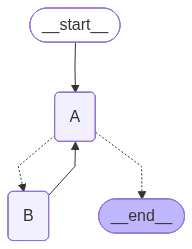

In [27]:
def route(state: State):
    if len(state['aggregate']) < 7:
        return 'B'
    else: 
        return END

graph_builder.add_edge(START, 'A')
graph_builder.add_conditional_edges('A', route)
graph_builder.add_edge('B', 'A')
# graph_builder.add_edge('A', END) # route 함수가 END를 반환하기 때문에, 이 코드는 불필요합니다.
graph = graph_builder.compile()

graph

In [28]:
graph.invoke({'aggregate': []})

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node A 처리 중 현재 상태값 : ['A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A']
Node A 처리 중 현재 상태값 : ['A', 'B', 'A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A', 'B', 'A']
Node A 처리 중 현재 상태값 : ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

### 부록

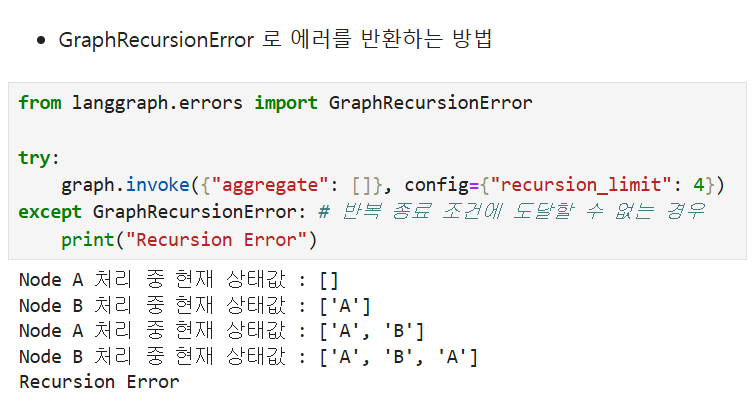

## 더 복잡한 조건 반복 처리하기

In [29]:
import operator
from typing_extensions import TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [30]:
def a(state: State):
    print(f'Node A 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Node C 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Node D 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["D"]}


graph_builder = StateGraph(State)
graph_builder.add_node('A', a)
graph_builder.add_node('B', b)
graph_builder.add_node('C', c)
graph_builder.add_node('D', d)

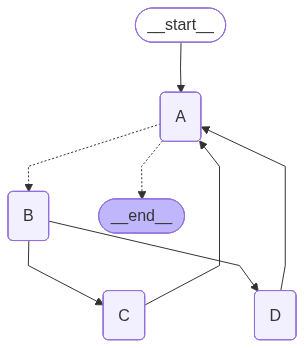

In [33]:
def route(state: State) -> Literal['B', END]: # Literal['B', END]: 'B' 또는 END 중 하나만 반환
                                              # 특정 반환값만 허용 (분기 조건 제한)
    if len(state['aggregate']) < 7:
        return 'B'
    return END

graph_builder.add_edge(START, "A")
graph_builder.add_conditional_edges("A", route)
graph_builder.add_edge("B", "C")
graph_builder.add_edge("B", "D")
graph_builder.add_edge(["C", "D"], "A")
graph = graph_builder.compile()

graph

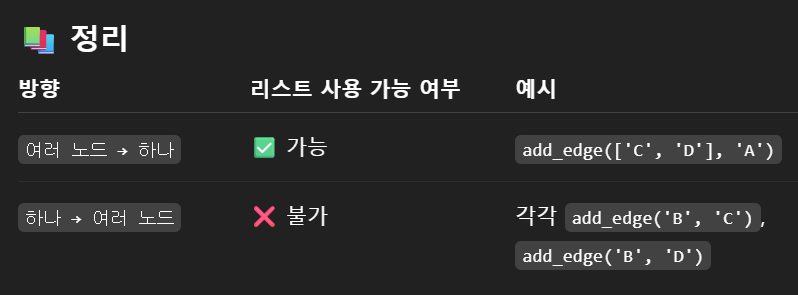

In [ ]:
# graph.invoke({"aggregate": []})
result = graph.invoke({"aggregate": []})

## 왜 위 코드에선 {'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']} 같은 최종 반환이 안될까?

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node C 처리 중 현재 상태값 : ['A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D']
Node B 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A']
Node C 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


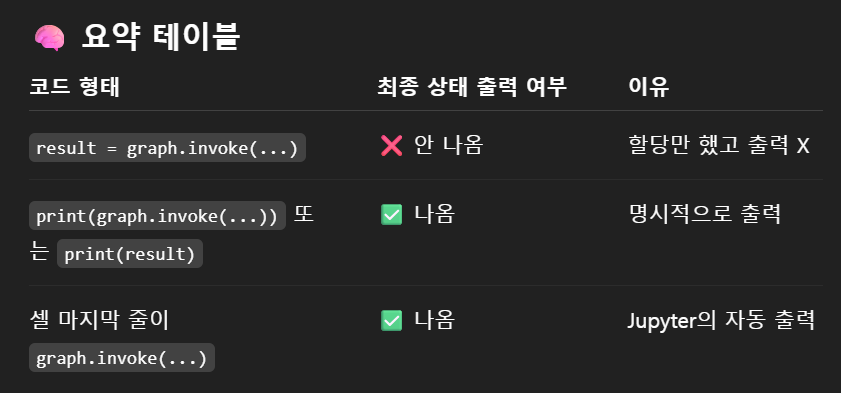

## 사용자 입력에 따른 반복 조건 설정

In [4]:
from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages 

class Messages(TypedDict):
    human_messages: Annotated[list[HumanMessage], add_messages]
    ai_messages: Annotated[list[AIMessage], add_messages]

class Retry_num(TypedDict):
    repeat: int

class State(Messages, Retry_num):
    pass

In [5]:
def chatbot(state: State):
    repeat = state['repeat']
    user_input = input(f'(현재 {repeat}번째 답변) 사용자 입력:')
    ai_messages = AIMessage(f'{repeat} 답변중!')

    return {'human_messages': [HumanMessage(content=user_input)], 'ai_messages': [ai_messages]}


def retry(state: State):
    return {'repeat': state['repeat'] + 1}

graph_builder = StateGraph(State)
graph_builder.add_node('bot', chatbot)
graph_builder.add_node('retry', retry)

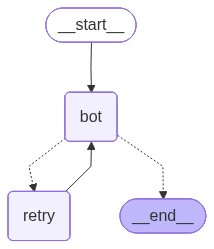

In [6]:
def route(state: State):
    last_user_msg = state["human_messages"][-1].content
    if not any(x in last_user_msg for x in ['quit', '그만']):
        return 'retry'
    return END

graph_builder.add_edge(START, 'bot')
graph_builder.add_conditional_edges('bot', route)
graph_builder.add_edge('retry', 'bot')
graph = graph_builder.compile()

graph

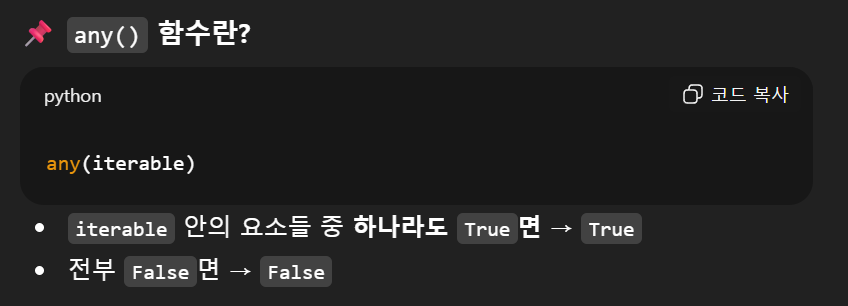

In [11]:

for chunk in graph.stream({
    "human_messages": [HumanMessage(content='계속')],
    "repeat": 0
}, stream_mode="updates"):
    print(chunk)
    for node, value in chunk.items():
        if node:
            print(node)
        if "messages" in value:
            print(value['messages'].content)

{'bot': {'human_messages': [HumanMessage(content='하이', additional_kwargs={}, response_metadata={}, id='5d7e7ae4-d0c1-4295-8138-e86133d9d328')], 'ai_messages': [AIMessage(content='0 답변중!', additional_kwargs={}, response_metadata={}, id='a7f14577-e1b3-4d6f-a758-57ef524fa63d')]}}
bot
{'retry': {'repeat': 1}}
retry
{'bot': {'human_messages': [HumanMessage(content='마이', additional_kwargs={}, response_metadata={}, id='6f2c7f02-d80e-48bf-b68b-78cf29b07fe9')], 'ai_messages': [AIMessage(content='1 답변중!', additional_kwargs={}, response_metadata={}, id='895bd127-b1c7-41e9-93cb-a2ba96424478')]}}
bot
{'retry': {'repeat': 2}}
retry
{'bot': {'human_messages': [HumanMessage(content='네임', additional_kwargs={}, response_metadata={}, id='eda88f1f-e7c1-437c-802c-d10c284856a2')], 'ai_messages': [AIMessage(content='2 답변중!', additional_kwargs={}, response_metadata={}, id='70f55288-ccc6-416a-bde4-b588ad2b2e69')]}}
bot
{'retry': {'repeat': 3}}
retry
{'bot': {'human_messages': [HumanMessage(content='이즈', additi

In [14]:
graph.invoke({"human_messages": [HumanMessage(content='계속')], "repeat": 0})

{'human_messages': [HumanMessage(content='계속', additional_kwargs={}, response_metadata={}, id='53545b9d-7355-466e-b293-76870c0aa725'),
  HumanMessage(content='야호', additional_kwargs={}, response_metadata={}, id='9f5b03f4-d95e-42d6-9d59-6230f64b3b08'),
  HumanMessage(content='제', additional_kwargs={}, response_metadata={}, id='43c88739-5753-4866-ab69-aa84e54a0ae4'),
  HumanMessage(content='이름은', additional_kwargs={}, response_metadata={}, id='759dfad1-42d2-4cd6-bf29-86f96d4aba4e'),
  HumanMessage(content='박진우', additional_kwargs={}, response_metadata={}, id='478aae7b-470e-4835-9b98-3c4d25f457a7'),
  HumanMessage(content='입니다.', additional_kwargs={}, response_metadata={}, id='c8684243-0f9d-4f10-8742-8de9d1d6d359'),
  HumanMessage(content='잘 부탁드려요!', additional_kwargs={}, response_metadata={}, id='1d609eb3-6830-413c-bcc0-824bc996240f'),
  HumanMessage(content='그만', additional_kwargs={}, response_metadata={}, id='65f84c54-a30d-426d-ae6c-1bd06641dcaa')],
 'ai_messages': [AIMessage(content='